<a href="https://colab.research.google.com/github/natitedros/CNN-Playground/blob/main/cursor_to_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [67]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import kagglehub
from kagglehub import KaggleDatasetAdapter
from PIL import Image

In [ ]:
# Load the latest version
file_path = "A_Z Handwritten Data.csv"
df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "sachinpatel21/az-handwritten-alphabets-in-csv-format",
  file_path,
)

/tmp/ipython-input-1099100609.py:3: DeprecationWarning: Use dataset_load() instead of load_dataset(). load_dataset() will be removed in a future version.
  df = kagglehub.load_dataset(


Using Colab cache for faster access to the 'az-handwritten-alphabets-in-csv-format' dataset.


In [82]:
train_images = df.iloc[:, 1:].values.astype('float32') / 255.0
train_labels = df.iloc[:, 0].values

In [39]:
train_images.shape

(372450, 784)

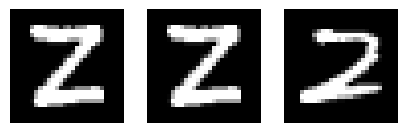

In [40]:
fig, axes = plt.subplots(1, 3, figsize=(5, 5))
for i in range(3):
  axes[i].imshow(train_images[len(train_images)-1-i].reshape(28,28), cmap='gray')
  axes[i].axis('off')
plt.show()

In [83]:
model = models.Sequential([
    layers.Dense(128, activation='relu', input_shape=(784,)),  # Added input_shape
    layers.Dropout(0.2),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(26, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [42]:
model.compile(optimizer='adam',
              # uses the negative log function when calculating probability
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
history = model.fit(
    train_images,
    train_labels,
    epochs=2
)

Epoch 1/2
11640/11640 ━━━━━━━━━━━━━━━━━━━━ 54s 5ms/step - accuracy: 0.8848 - loss: 0.4162
Epoch 2/2
11640/11640 ━━━━━━━━━━━━━━━━━━━━ 53s 5ms/step - accuracy: 0.9660 - loss: 0.1182


In [55]:
probabilities = model.predict(train_images[4573].reshape(1, 784))
predictions = np.argmax(probabilities, axis=1)
print(f"Predicted: {chr(ord('A')+predictions[0])}")
print(f"Actual: {chr(ord('A')+train_labels[4573])}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
A


In [56]:
from matplotlib.backends.backend_agg import FigureCanvasAgg

In [78]:
class MouseStringDetector:

    def __init__(self, csv_file, dt=0.015):
        self.df = pd.read_csv(csv_file)
        self.dt = dt  # fixed sampling interval in seconds (15ms)
        self.positions = None
        self.segments = []

    def integrate_velocities(self):

        vx = self.df['velocity_x'].values
        vy = self.df['velocity_y'].values

        # distance = v * time
        # cumulative sum to represent the position
        x = np.cumsum(vx * self.dt)
        y = np.cumsum(vy * self.dt)

        self.positions = np.column_stack([x, -y])

        return self.positions


    def segment_characters(self, pause_threshold=0.1, min_segment_length=5, min_pause_duration_ms=500):

        # min_pause_duration_ms taken as 800 because the csv character break duration is 1 second
        vx = self.df['velocity_x'].values
        vy = self.df['velocity_y'].values

        # Calculate speed (magnitude of velocity)
        speed = np.sqrt(vx**2 + vy**2)

        # Find pauses (low speed regions)
        pauses = speed < pause_threshold

        # Convert min_pause_duration from ms to number of samples
        min_pause_samples = int(min_pause_duration_ms / (self.dt * 1000))

        # Find pause boundaries
        pause_changes = np.diff(pauses.astype(int), prepend=0)
        pause_starts = np.where(pause_changes == 1)[0]
        pause_ends = np.where(pause_changes == -1)[0]

        # Segment based on pauses (only if pause is long enough)
        segments = []
        start_idx = 0

        for pause_start, pause_end in zip(pause_starts, pause_ends):
            pause_length = pause_end - pause_start

            # Only segment if pause is long enough
            if pause_length >= min_pause_samples:
                if pause_start - start_idx >= min_segment_length:
                    segments.append((start_idx, pause_start))
                start_idx = pause_end

        # Add final segment
        if len(self.positions) - start_idx >= min_segment_length:
            segments.append((start_idx, len(self.positions)))

        self.segments = segments
        return segments


    def detect_string(self):

        # Step 1: Integrate velocities to positions
        print("Step 1: Integrating velocities to positions...")
        self.integrate_velocities()

        # Step 2: Segment into characters
        print("Step 2: Segmenting characters...")
        self.segment_characters()
        print(f"Found {len(self.segments)} potential characters")

        return

    def visualize(self):

            # Separate pages for each character
            for i, (start, end) in enumerate(self.segments):
                segment_pos = self.positions[start:end]

                fig = plt.figure(figsize=(7, 7), dpi=4)

                plt.plot(segment_pos[:, 0], segment_pos[:, 1],
                        'k-', linewidth=10)
                canvas = FigureCanvasAgg(fig)
                canvas.draw()
                image = np.asarray(canvas.buffer_rgba())


                # Convert to PIL Image, then to grayscale
                pil_image = Image.fromarray(image.astype('uint8'), mode='RGBA')
                grayscale_image = pil_image.convert('L')
                grayscale_array = np.array(grayscale_image)
                grayscale_array = grayscale_array.reshape(1,784)

                probabilities = model.predict(grayscale_array)
                predictions = np.argmax(probabilities, axis=1)
                letter = chr(ord('A')+predictions[0])
                print(f"The {i}th letter: {letter}")

                plt.axis('off')
                plt.imshow(image)
                plt.show()
                plt.close()


In [61]:
from google.colab import files
uploaded = files.upload()

Saving mouse_velocities2.csv to mouse_velocities2.csv


In [79]:
detector = MouseStringDetector('mouse_velocities2.csv')
detector.detect_string()

detector.visualize()

Step 1: Integrating velocities to positions...
Step 2: Segmenting characters...
Found 5 potential characters
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
The 0th letter: A


/tmp/ipython-input-1709233989.py:94: DeprecationWarning: 'mode' parameter is deprecated and will be removed in Pillow 13 (2026-10-15)
  pil_image = Image.fromarray(image.astype('uint8'), mode='RGBA')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
The 1th letter: A


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
The 2th letter: A


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
The 3th letter: A


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
The 4th letter: A
